AGCO Case Analysis and Models created by Ashish Gupta

In [1]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Load the csv file.

import os
from six.moves import urllib

DataFile = pd.read_csv("U:\\data.csv") #read the data from the csv file.

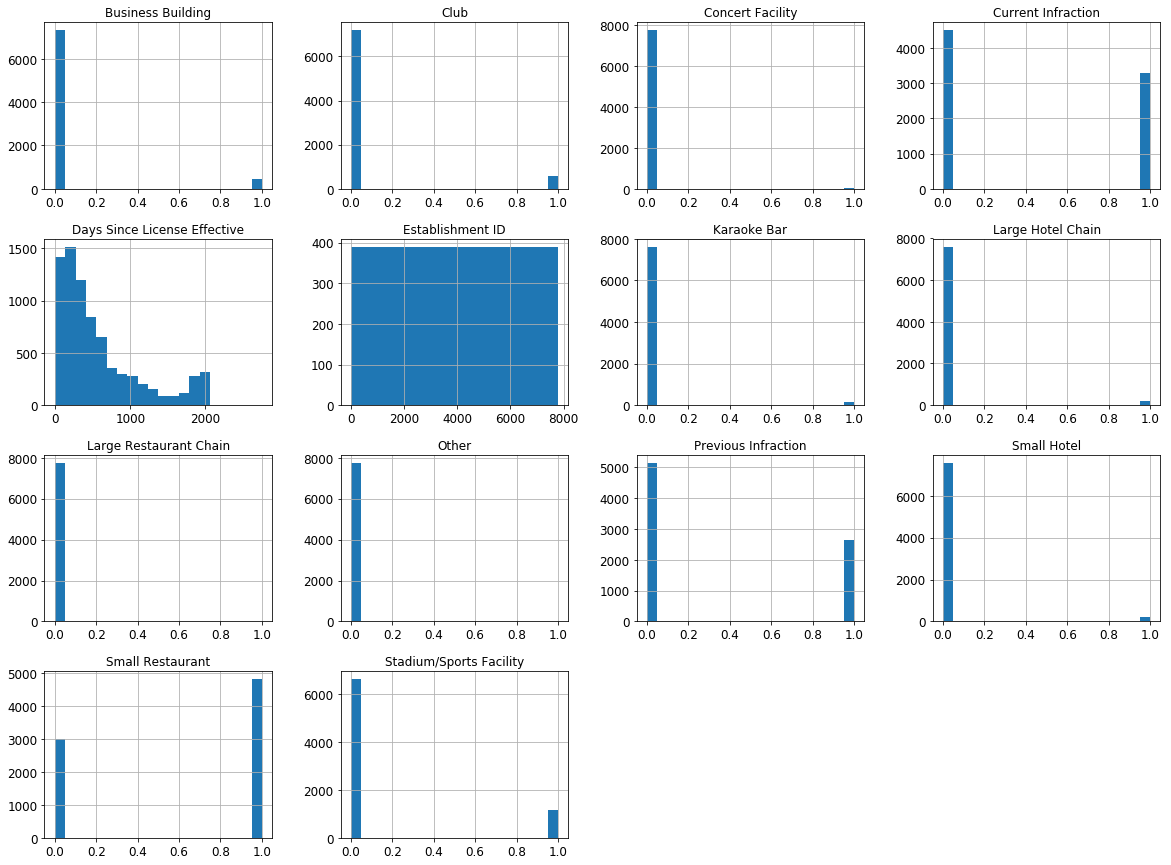

In [3]:
# Explore / Visualize the data

import matplotlib.pyplot as plt
DataFile.hist(bins=20, figsize=(20,15))
plt.show()

In [4]:
# We can see that the days are not normalized. But before normalizing the data, we create the train and test split.

from sklearn.model_selection import StratifiedShuffleSplit

DataFile = DataFile.drop('Establishment ID',axis=1)
DataFile = DataFile.drop('Postal First', axis=1)
DataFile = DataFile.drop('Email on file', axis=1)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_index, test_index in split.split(DataFile, DataFile["Current Infraction"] ):
    train_set = DataFile.loc[train_index]
    test_set = DataFile.loc[test_index]

#the Y Variable
train_set_y = train_set["Current Infraction"].copy()
test_set_y = test_set["Current Infraction"].copy()

#the X variables
train_set_X = train_set.drop("Current Infraction", axis=1)
test_set_X = test_set.drop("Current Infraction", axis=1)

In [5]:
#Now to normalize the number of days - we will create a pipeline.

Training_Transformed_X = train_set_X[['Days Since License Effective']]

In [6]:
Training_NonTransformed_X = train_set_X[['Club', 'Business Building', 'Small Hotel' ,'Small Restaurant',
                                        'Large Hotel Chain','Concert Facility','Stadium/Sports Facility',
                                        'Karaoke Bar','Other','Large Restaurant Chain','Previous Infraction']]

In [7]:
#Create numerical pipeline to transform numerical values

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Convert the non transformed Dataframe into list.
Training_Transformed_list = list(Training_Transformed_X)
Training_NonTransformed_list = list(Training_NonTransformed_X)

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(Training_Transformed_list)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(Training_NonTransformed_list))
    ])


In [8]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
    ])

Final_training_X = full_pipeline.fit_transform(train_set_X)
Final_test_X = full_pipeline.transform(test_set_X)

In [9]:
#Now we will build the prediction models - Logistic Regression, Gradient Boosting and Random Forest.
#import the libraries for all the classifiers.

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [37]:
#We start our analysis with the Logistic Regression Classifer using Stats models
import statsmodels.api as sm
Logistic_Regression = sm.Logit(train_set_y,Final_training_X).fit()
Logistic_Regression.summary()

Optimization terminated successfully.
         Current function value: 0.284426
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Current Infraction   No. Observations:                 6229
Model:                          Logit   Df Residuals:                     6217
Method:                           MLE   Df Model:                           11
Date:                Thu, 03 May 2018   Pseudo R-squ.:                  0.5822
Time:                        10:12:32   Log-Likelihood:                -1771.7
converged:                       True   LL-Null:                       -4240.4
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1542      0.046      3.360      0.001       0.064       0.244
x2            -2.0294      0.165    -12.327      0.000      -2.352      -1.707
x3            -2.4104      0.193    -12.480      0.000      -2.789      -2.032
x4            -2.2790      0.268     -8.499      0.000      -2.805      -1.753
x5            -1.8788      0.059    -32.096      0.000      -1.994      -1.764
x6            -2.0939      0.299     -6.994      0.000      -2.681      -1.507
x7            -0.3475      0.317     -1.095      0.274      -0.970       0.275
x8            -1.8638      0.124    -15.027      0.000      -2.107      -1.621
x9            -1.5782      0.314     -5.019      0.000      -2.195      -0.962
x10           -1.3497      0.536     -2.516      0.012      -2.401      -0.298
x11           -0.5314      0.481     -1.105      0.269      -1.474       0.411
x12            5.8809      0.169     34.829      0.000       5.550       6.212
==============================================================================
"""

In [59]:
#Now Perform Backward Elimination to get Final Logistic Model

X_opt = Final_training_X[:,[0,1,2,3,4,5,7,8,9,11]] # Only take the significant variables.

logregressor_stp = sm.Logit(endog = train_set_y, exog = X_opt).fit()
logregressor_stp.summary()

Optimization terminated successfully.
         Current function value: 0.284622
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Current Infraction   No. Observations:                 6229
Model:                          Logit   Df Residuals:                     6219
Method:                           MLE   Df Model:                            9
Date:                Thu, 03 May 2018   Pseudo R-squ.:                  0.5819
Time:                        10:50:09   Log-Likelihood:                -1772.9
converged:                       True   LL-Null:                       -4240.4
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1463      0.046      3.199      0.001       0.057       0.236
x2            -2.0283      0.165    -12.322      0.000      -2.351      -1.706
x3            -2.3966      0.193    -12.425      0.000      -2.775      -2.019
x4            -2.2781      0.268     -8.497      0.000      -2.804      -1.753
x5            -1.8788      0.059    -32.100      0.000      -1.994      -1.764
x6            -2.0914      0.299     -6.988      0.000      -2.678      -1.505
x7            -1.8660      0.124    -15.047      0.000      -2.109      -1.623
x8            -1.5794      0.314     -5.023      0.000      -2.196      -0.963
x9            -1.3521      0.536     -2.521      0.012      -2.403      -0.301
x10            5.8786      0.169     34.818      0.000       5.548       6.210
==============================================================================
"""

In [62]:
#Odds Ratio for the new logistic regression model
np.exp(logregressor_stp.params)

x1       1.157488
x2       0.131562
x3       0.091030
x4       0.102483
x5       0.152770
x6       0.123510
x7       0.154734
x8       0.206103
x9       0.258693
x10    357.317698
dtype: float64

In [63]:
#Confidence Intervals for the new Logistic Regressions

params = logregressor_stp.params
conf = logregressor_stp.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

           2.5%       97.5%          OR
x1     1.058292    1.265982    1.157488
x2     0.095283    0.181653    0.131562
x3     0.062375    0.132850    0.091030
x4     0.060598    0.173320    0.102483
x5     0.136213    0.171340    0.152770
x6     0.068696    0.222063    0.123510
x7     0.121345    0.197309    0.154734
x8     0.111290    0.381693    0.206103
x9     0.090419    0.740134    0.258693
x10  256.648011  497.474876  357.317698


In [52]:
Test: # Lets try getting similar insights using sklearn

Logistic_Regression = LogisticRegression(random_state = 42)
Logistic_Regression.fit(Final_training_X,train_set_y)
Logistic_Regression.coef_

array([[ 0.14201384, -1.1494698 , -1.50367092, -1.34467885, -1.02966586,
        -1.14818823,  0.44884526, -1.00220664, -0.66754568, -0.40047781,
         0.25291622,  5.71180242]])

In [53]:
np.exp(Logistic_Regression.coef_)

array([[  1.15259260e+00,   3.16804696e-01,   2.22312568e-01,
          2.60623394e-01,   3.57126271e-01,   3.17210962e-01,
          1.56650223e+00,   3.67068560e-01,   5.12966016e-01,
          6.69999837e-01,   1.28777538e+00,   3.02415658e+02]])

As you may notice, that most of the statistics are not easy to get from scikit-learn (where model evaluation is mostly done using cross-validation), So Stats models can be used to present the business insights. 

In [27]:
#Now create Random Forest and Gradient Boosting.

# Random Forest Classifier
random_forest_Classifier = RandomForestClassifier()
random_forest_Classifier.fit(Final_training_X,train_set_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
# Gradient Boosting Classifier
GB_Classifier = GradientBoostingClassifier(random_state = 42)
GB_Classifier.fit(Final_training_X,train_set_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [10]:
# Now Tune the models.

#Design the random forest classifier and use Grid Search technique to tune the hyper parameters.

# Random Forest Classifier

n_estimators = [3, 7]
max_features = [0.1, 0.3]
max_depth = [2, 7, 10] 
oob_score = [True, False]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5]
max_leaf_nodes = [2, 10, 50]

parameter_random_forest = {'n_estimators' : n_estimators, 'max_features' : max_features,
                     'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                    'oob_score' : oob_score, 'min_samples_leaf': min_samples_leaf, 
                     'max_leaf_nodes' : max_leaf_nodes}
             
Random_Forest_Classifier = RandomForestClassifier(random_state = 42)

#use grid search to tune the model

grid_search_RndmForest = GridSearchCV(Random_Forest_Classifier,parameter_random_forest, cv = 4, scoring='roc_auc', refit = True,
                                     n_jobs = -1, verbose=2)

grid_search_RndmForest.fit(Final_training_X,train_set_y)
             
forest_best_params_ = grid_search_RndmForest.best_params_
forest_best_estimators_ = grid_search_RndmForest.best_estimator_

print(forest_best_params_)
print(forest_best_estimators_)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s


{'max_depth': 2, 'max_features': 0.3, 'max_leaf_nodes': 10, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 7, 'oob_score': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=0.3, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:   13.2s finished


In [11]:
# Build the next classifier : Gradient Boosting Classifier

GB_Classifier = GradientBoostingClassifier(random_state = 42)

n_estimators = [3, 7]
learning_rate = [0.1, 0.01, .001]
max_depth = [2,7,10]
max_features = [4, 6]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5]
max_leaf_nodes = [2, 10, 50]
                            
parameter_GB_Classifier = {'n_estimators' : n_estimators, 'learning_rate' : learning_rate,
                              'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                              'min_samples_leaf' : min_samples_leaf, 'max_features' : max_features,
                              'max_leaf_nodes' : max_leaf_nodes}

grid_search_GB_Classifier = GridSearchCV(GB_Classifier, parameter_GB_Classifier, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_GB_Classifier.fit(Final_training_X,train_set_y)

GB_Classifier_best_params_ = grid_search_GB_Classifier.best_params_

GB_Classifier_best_estimators_ = grid_search_GB_Classifier.best_estimator_

print(GB_Classifier_best_params_)

print(GB_Classifier_best_estimators_)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1631 tasks      | elapsed:   13.2s


{'learning_rate': 0.1, 'max_depth': 7, 'max_features': 6, 'max_leaf_nodes': 10, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 7}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=6, max_leaf_nodes=10, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=0.1,
              min_samples_split=0.1, min_weight_fraction_leaf=0.0,
              n_estimators=7, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:   13.6s finished


In [64]:
# Now Create the Logistic Regression model using Sklearn approach

X_opt = Final_training_X[:,[0,1,2,3,4,5,7,8,9,11]] #taking the significant variables - we will tune the model further.

Logistic_Regression = LogisticRegression(random_state = 42)
C = [0.0001, 0.001, 0.01, 0.1]
                            
parameter_LogReg = {'C' : C}
grid_search_LogReg = GridSearchCV(Logistic_Regression, parameter_LogReg, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_LogReg.fit(X_opt,train_set_y)

LogReg_best_params_ = grid_search_LogReg.best_params_
LogReg_best_estimators_ = grid_search_LogReg.best_estimator_

print(LogReg_best_params_)
print(LogReg_best_estimators_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    5.7s finished


{'C': 0.1}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [65]:
#Evaluate the Random Forest Model on the Training set

from sklearn.model_selection import cross_val_predict
y_probas_forest = cross_val_predict(Random_Forest_Classifier,Final_training_X,train_set_y, cv=4,
                                    method="predict_proba")
y_forest_scores = y_probas_forest[:, 1] # score = proba of positive class

#Evaluate the Gradient Boosting Model on the Training set

y_probas_gradient = cross_val_predict(GB_Classifier,Final_training_X,train_set_y, cv=4,
                                    method="predict_proba")

y_gradient_scores = y_probas_gradient[:, 1] # score = proba of positive class

#Evaluate The logistic Regression model on Training set

y_probas_logistic = cross_val_predict(Logistic_Regression,Final_training_X,train_set_y, cv=4,
                                    method="predict_proba")

y_logistic_scores = y_probas_logistic[:, 1] # score = proba of positive class

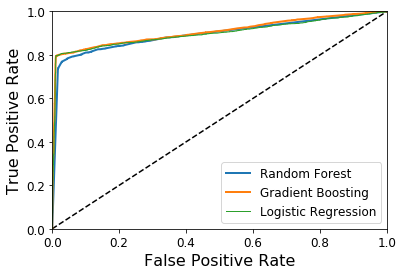

In [66]:
#Evaluate the model performance using ROC Curve

from sklearn.metrics import roc_curve

# for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_set_y,y_forest_scores)

# for gradient boosting
fpr_gradient, tpr_gradient, thresholds_gradient = roc_curve(train_set_y,y_gradient_scores)

# for logistic regression
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(train_set_y,y_logistic_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_gradient, tpr_gradient, linewidth=2, label="Gradient Boosting")
plt.plot(fpr_logistic, tpr_logistic, linewidth=1, label="Logistic Regression")
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [67]:
# Calculate the AUC and choose the best model. From the result - we can see Gradient Boosting is the best model.

from sklearn.metrics import roc_auc_score

auc_RandomClassifier = roc_auc_score(train_set_y,y_forest_scores)
auc_GradientBoosting = roc_auc_score(train_set_y,y_gradient_scores)
auc_LogisticRegression = roc_auc_score(train_set_y,y_logistic_scores)

print(auc_RandomClassifier)
print(auc_GradientBoosting)
print(auc_LogisticRegression)

0.894612229798
0.90633121928
0.898645473284


In [68]:
#Create the confusion Matrix for Gradient Boosting - which is the best model
from sklearn.metrics import confusion_matrix

#need to create a binary classifier as Classification metrics can't handle a mix of binary and continuous targets
predict_Gboosting = cross_val_predict(GB_Classifier,Final_training_X,train_set_y, cv=4)
print(confusion_matrix(train_set_y,predict_Gboosting))

#Print the Precision / Recall Score
from sklearn.metrics import precision_score, recall_score
print(precision_score(train_set_y,predict_Gboosting))
print(recall_score(train_set_y,predict_Gboosting))

[[3556   48]
 [ 536 2089]]
0.977538605522
0.79580952381


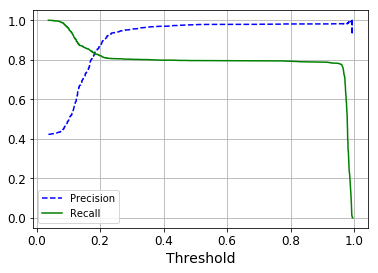

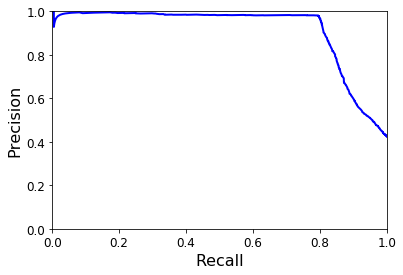

In [69]:
#Now I will create a precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(train_set_y,y_gradient_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.grid(True)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

    
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [70]:
# Since we got the best model : Gradient Boosting, We got 79% of recall. 
#We can now adjust the threshhold to 90-95% to get more positive cases - Positive cases means more defaults.

Recall_Threshhold = (y_gradient_scores > .11)
print(precision_score(train_set_y,Recall_Threshhold))
print(recall_score(train_set_y,Recall_Threshhold))

0.521031494399
0.939047619048


In [20]:
#Now we use this new threshhold to predict the values on Training set using new threshhold
from sklearn.metrics import accuracy_score

NewR_Threshhold = Recall_Threshhold.astype(int)
grid_search_GB_Classifier.fit(Final_training_X,NewR_Threshhold)

y_Train_pred = GB_Classifier_best_estimators_.predict(Final_training_X)
accuracy_score(train_set_y, y_Train_pred)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:    9.2s finished


0.90576336490608444

In [21]:
#Next we predict the results on the test set
y_Test_pred = GB_Classifier_best_estimators_.predict(Final_test_X)
accuracy_score(test_set_y , y_Test_pred)

0.90308087291399231